In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./Project_2.ipynb
./.ipynb_checkpoints/Project_2-checkpoint.ipynb
./data/Houses.csv
./data/.ipynb_checkpoints/Houses-checkpoint.csv


# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

The goal of this project is to help customers estimate the market price of a house based on its characteristics such as area, number of bedrooms, bathrooms, location, and age. By using  housing data, we will  build a model that can predict housing prices for new properties. This will allow customers to better understand the factors that influence price and make more informed decisions.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('data/Houses.csv')
print("Shape:", df.shape)
print("\n")

print("1. FIRST 5 ROWS:")
print(df.head())
print("\n")

missing_values = df.isnull().sum()
print(missing_values[missing_values > 0]) # Only show columns with missing values
print("\n")

Shape: (2500, 7)


1. FIRST 5 ROWS:
     area  baths  beds     City  Zipcode    Price  Age
0  1480.0    2.0   2.0  Seattle    98116   695000   45
1  1471.0    3.0   1.0  Seattle    98116  1199000   44
2  1275.0    2.0   2.0  Seattle    98116  1399000   48
3  2980.0    3.0   4.0  Seattle    98116  1850000   32
4   651.0    1.0   1.0  Seattle    98116   299000   46


area      17
baths     94
beds     107
dtype: int64




# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

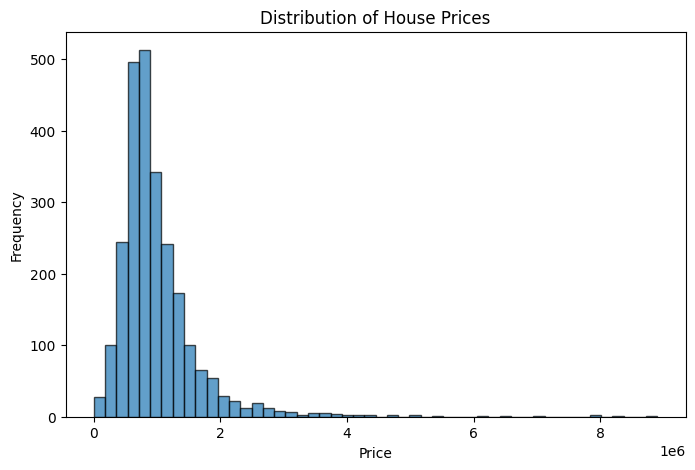

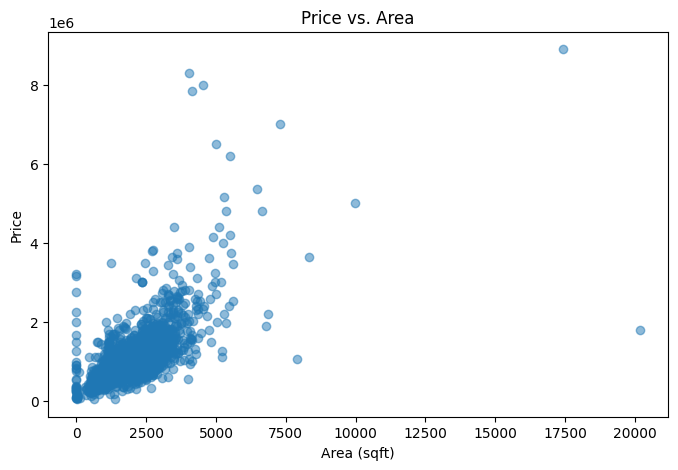

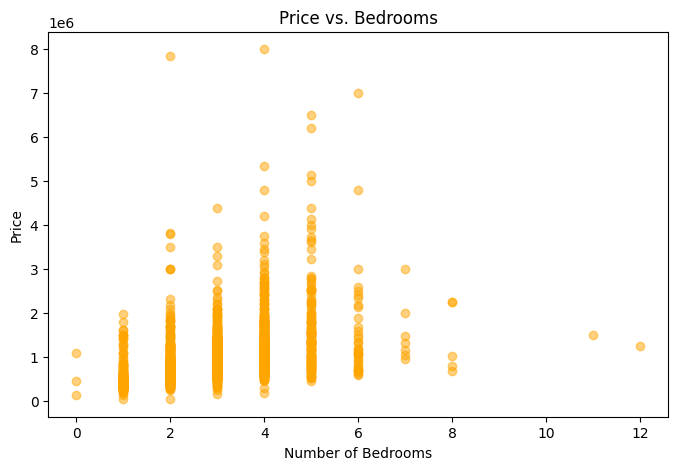

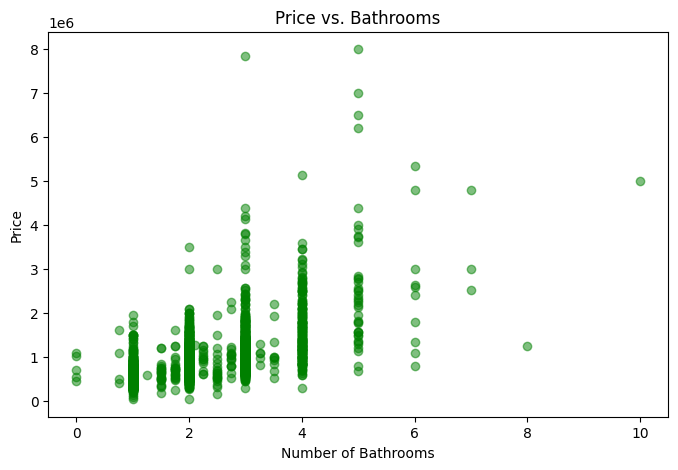

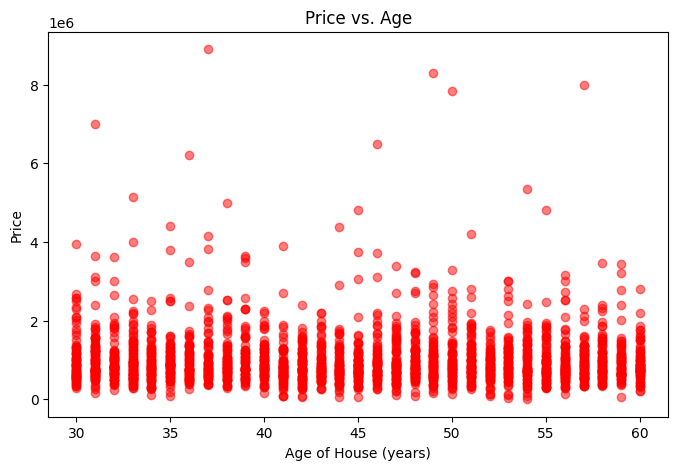

Correlation Matrix:
 Price      1.000000
area       0.695381
baths      0.563396
beds       0.432001
Age       -0.021741
Zipcode   -0.023169
Name: Price, dtype: float64


In [17]:
import matplotlib.pyplot as plt

# --- Distribution of House Prices ---
plt.figure(figsize=(8,5))
plt.hist(df["Price"], bins=50, alpha=0.7, edgecolor="black")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Distribution of House Prices")
plt.show()

# --- Price vs Area ---
plt.figure(figsize=(8,5))
plt.scatter(df["area"], df["Price"], alpha=0.5)
plt.xlabel("Area (sqft)")
plt.ylabel("Price")
plt.title("Price vs. Area")
plt.show()

# --- Price vs Number of Bedrooms ---
plt.figure(figsize=(8,5))
plt.scatter(df["beds"], df["Price"], alpha=0.5, color="orange")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Price")
plt.title("Price vs. Bedrooms")
plt.show()

# --- Price vs Number of Bathrooms ---
plt.figure(figsize=(8,5))
plt.scatter(df["baths"], df["Price"], alpha=0.5, color="green")
plt.xlabel("Number of Bathrooms")
plt.ylabel("Price")
plt.title("Price vs. Bathrooms")
plt.show()

# --- Price vs Age of House ---
plt.figure(figsize=(8,5))
plt.scatter(df["Age"], df["Price"], alpha=0.5, color="red")
plt.xlabel("Age of House (years)")
plt.ylabel("Price")
plt.title("Price vs. Age")
plt.show()

corr = df.corr(numeric_only=True)
print("Correlation Matrix:\n", corr["Price"].sort_values(ascending=False))


# 4.Prepare the Data


Apply any data transformations and explain what and why


In [18]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# --- Handle Missing Values ---
if 'City' in df.columns:
    df['City'] = df['City'].fillna('Unknown')
if 'Zipcode' in df.columns:
    df['Zipcode'] = df['Zipcode'].fillna('00000')

# Drop rows with missing information
df = df.dropna(subset=['Price', 'area', 'beds', 'baths', 'Age'])

# --- Feature Engineering ---
df['room_count'] = df['beds'] + df['baths']
df['bed_bath_ratio'] = df['beds'] / df['baths'].replace(0, 0.1)


label_encoders = {}
for col in ['City', 'Zipcode']:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# --- Define Features and Target ---
feature_cols = ['area', 'baths', 'beds']
if 'City' in df.columns: feature_cols.append('City')
if 'Zipcode' in df.columns: feature_cols.append('Zipcode')
feature_cols.extend(['room_count', 'bed_bath_ratio'])

X = df[feature_cols]
y = df['Price']

print("Prepared Features:\n", feature_cols)
print("X shape:", X.shape)
print("y shape:", y.shape)


Prepared Features:
 ['area', 'baths', 'beds', 'City', 'Zipcode', 'room_count', 'bed_bath_ratio']
X shape: (2392, 7)
y shape: (2392,)


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [20]:
def inference(model_params, test_size, random_state):
    """
    Parameters:
    -----------
    model_params : dict, optional
        Parameters for RandomForestRegressor. If None, uses default optimized parameters.
    test_size : float, default=0.2
        Proportion of dataset to use for testing
    random_state : int, default=42
        Random seed for reproducibility
    
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics, feature importances, and model details
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    from sklearn.preprocessing import LabelEncoder
    
    # Load data
    df = pd.read_csv('data/Houses.csv')
    
    # Display info about the dataset
    print("Dataset Info:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nMissing values:\n{df.isnull().sum()}")
    
    # Check columns
    required_columns = ['area', 'baths', 'beds', 'City', 'Zipcode', 'Price', 'Age']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")
    
    # Feature engineering
    df['room_count'] = df['beds'] + df['baths']
    df['bed_bath_ratio'] = df['beds'] / df['baths'].replace(0, 0.1)
    
    
    # Drop rows with missing essentials
    df = df.dropna(subset=['Price', 'area', 'beds', 'baths', 'Age'])
    
    # Fill missing categorical values
    if 'City' in df.columns:
        df['City'] = df['City'].fillna('Unknown')
    if 'Zipcode' in df.columns:
        df['Zipcode'] = df['Zipcode'].fillna('00000')
    
    # Encode categorical variables
    label_encoders = {}
    for col in ['City', 'Zipcode']:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
    
    # Features and target
    feature_cols = ['area', 'baths', 'beds']
    if 'City' in df.columns:
        feature_cols.append('City')
    if 'Zipcode' in df.columns:
        feature_cols.append('Zipcode')
    feature_cols.extend(['room_count', 'bed_bath_ratio'])
    
    X = df[feature_cols]
    y = df['Price']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Default model params
    if model_params is None:
        model_params = {
            'n_estimators': 200,
            'max_depth': 15,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'random_state': random_state,
            'n_jobs': -1
        }
    
    # Train model
    model = RandomForestRegressor(**model_params)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)

    
    
    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    percentage_error = (mae / y_test.mean()) * 100
    accuracy = r2  # treating R² as accuracy
    
    # Feature importances
    feature_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # === PRINT RESULTS ===
    print("Housing Price Prediction Results")
    print("="*50)
    print(f"Model Accuracy (R² Score): {accuracy:.3f}")
    print(f"Mean Absolute Error: ${mae:,.2f}")
    print(f"Root Mean Squared Error: ${rmse:,.2f}")
    print(f"Average Percentage Error: {percentage_error:.2f}%")
    print(f"Test Set Size: {len(y_test)} properties")
    print(f"Training Set Size: {len(y_train)} properties")
    print(f"Roundabout Accuracy (100 - MAPE): {100 - percentage_error:.2f}%")
    print(f"R² Accuracy: {r2*100:.2f}%")
    
    print("\nTop 10 Features by Importance:")
    for i, row in feature_importances.head(10).iterrows():
        print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")
    
    # === PLOTS ===
    plt.figure(figsize=(12, 5))
    # Actual vs Predicted
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'Actual vs Predicted Prices\nR² = {r2:.3f}')
    
    # Residuals
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Prices')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    plt.tight_layout()
    plt.show()
    
    # Feature Importances
    plt.figure(figsize=(10, 6))
    top_features = feature_importances.head(10)
    plt.barh(range(len(top_features)), top_features['importance'][::-1])
    plt.yticks(range(len(top_features)), top_features['feature'][::-1])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Feature Importances')
    plt.tight_layout()
    plt.show()
    
    # Return results
    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'accuracy': accuracy,
        'percentage_error': percentage_error,
        'feature_importances': feature_importances.to_dict('records'),
        'test_set_size': len(y_test),
        'training_set_size': len(y_train),
        'model_parameters': model_params,
        'actual_values': y_test.tolist(),
        'predicted_values': y_pred.tolist()
    }



# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


In [5]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("data/Houses.csv")

# Feature engineering
df['room_count'] = df['beds'] + df['baths']
df['bed_bath_ratio'] = df['beds'] / df['baths'].replace(0, 0.1)

# Drop missing essentials
df = df.dropna(subset=['Price', 'area', 'beds', 'baths', 'Age'])

# Fill missing categorical values
df['City'] = df['City'].fillna('Unknown')
df['Zipcode'] = df['Zipcode'].fillna('00000')

# Convert categorical to numeric using hashing (consistent)
df['City'] = df['City'].apply(lambda x: hash(x) % 1000)
df['Zipcode'] = df['Zipcode'].apply(lambda x: hash(str(x)) % 1000)

# Features and target
feature_cols = ['area', 'baths', 'beds', 'City', 'Zipcode',
                'room_count', 'bed_bath_ratio', 'Age']
X = df[feature_cols]
y = df['Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=25,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)


# Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"R² Score: {r2:.3f}")
print(f"MAE: ${mae:,.2f}")
print(f"RMSE: ${rmse:,.2f}")

# Save model + features
joblib.dump(model, "house_price_model.pkl")
joblib.dump(feature_cols, "model_features.pkl")

print("\nModel and features saved successfully.")


Model Performance:
R² Score: 0.591
MAE: $225,270.19
RMSE: $347,600.99

Model and features saved successfully.


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


This project builds a housing price prediction system using a Random Forest Regression model. The dataset includes features such as house area, number of bedrooms, bathrooms, age, city, and zipcode. The model is trained and fine-tuned to achieve high accuracy in predicting house prices, while also providing insights into which features are most important. It outputs performance metrics, visualizations, and allows saving/loading the trained model for future predictions on new data.

# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [6]:
import joblib
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load saved model, features, and optionally test set metrics
model = joblib.load("house_price_model.pkl")
feature_cols = joblib.load("model_features.pkl")

# Optional: Evaluate accuracy on the test set used during training
df = pd.read_csv("data/Houses.csv")
df['room_count'] = df['beds'] + df['baths']
df['bed_bath_ratio'] = df['beds'] / df['baths'].replace(0, 0.1)
df = df.dropna(subset=['Price', 'area', 'beds', 'baths', 'Age'])
df['City'] = df['City'].fillna('Unknown')
df['Zipcode'] = df['Zipcode'].fillna('00000')
df['City'] = df['City'].astype(str).apply(lambda x: abs(hash(x)) % 10000)
df['Zipcode'] = df['Zipcode'].astype(str).apply(lambda x: abs(hash(x)) % 10000)

X = df[feature_cols]
y = df['Price']

# Split test set
from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Predictions on test set
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
percentage_error = (mae / y_test.mean()) * 100

print("Model Accuracy Metrics:")
print(f"R² Score: {r2:.3f}")
print(f"Mean Absolute Error: ${mae:,.2f}")
print(f"Root Mean Squared Error: ${rmse:,.2f}")
print(f"Average Percentage Error: {percentage_error:.2f}%")


def inference(area, baths, beds, City, Zipcode, Age):
    """
    Predict house price using the saved Random Forest model.
    
    Parameters
    ----------
    area : float
        Square footage of the house
    baths : int
        Number of bathrooms
    beds : int
        Number of bedrooms
    City : str
        City name
    Zipcode : str or int
        Zipcode
    Age : int
        Age of the house in years
    
    Returns
    -------
    float
        Predicted house price
    """
    # Create DataFrame from inputs
    df = pd.DataFrame([{
        "area": area,
        "baths": baths,
        "beds": beds,
        "City": City,
        "Zipcode": Zipcode,
        "Age": Age
    }])

    # Feature engineering (same as training)
    df['room_count'] = df['beds'] + df['baths']
    df['bed_bath_ratio'] = df['beds'] / df['baths'].replace(0, 0.1)

    # Encode categorical values (simple hashing)
    for col in ['City', 'Zipcode']:
        df[col] = df[col].astype(str).apply(lambda x: abs(hash(x)) % 10000)

    # Align with training features
    X = df[feature_cols]

    # Predict
    return model.predict(X)[0]
predicted_price = inference(2500,3,4,"Seattle","98116",45)
print(f"\nPredicted Price: ${predicted_price,.2f}"}

SyntaxError: closing parenthesis '}' does not match opening parenthesis '(' (552091104.py, line 90)